In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [2]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'inverse learning rate':0.01,

        'inverse training epochs':5000,

        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [3]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [4]:
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [5]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [6]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [7]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [8]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

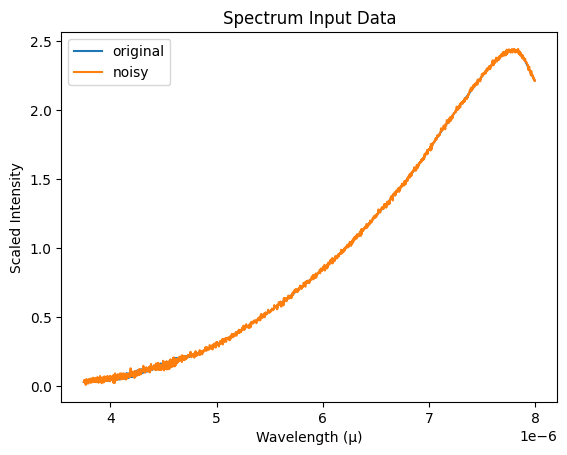

In [9]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [10]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)
spec_unscaled = scaler.inverse_transform(spec_scaled)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


In [11]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [12]:
spec_unscaled

array([[0.03105584, 0.03052205, 0.04107059, ..., 2.2237618 , 2.21893855,
        2.21433401],
       [0.02303472, 0.0224398 , 0.02986917, ..., 1.61469112, 1.61137908,
        1.60822492],
       [0.03321009, 0.03183994, 0.04156518, ..., 4.19873996, 4.18865979,
        4.1789976 ],
       ...,
       [0.02472354, 0.02407549, 0.03204759, ..., 3.12532968, 3.11816178,
        3.11130323],
       [0.03013358, 0.02888866, 0.03770118, ..., 3.33235318, 3.3246326 ,
        3.31724227],
       [0.05867424, 0.05706454, 0.07582961, ..., 2.89888822, 2.89231923,
        2.88603676]])

In [13]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.468595,1.386983,-0.055566,0.415908,-0.488088,0.666028,-1.094108,-0.403886,1.112096,0.044725,...,-0.313301,-0.312074,-0.305876,-0.308911,-0.318635,-0.307594,-0.315728,-0.318505,-0.309702,-0.314098
1,0.023044,0.627595,-0.555701,-0.518554,-0.790844,0.436625,-1.683073,-0.616311,-0.935019,-0.830250,...,-0.802942,-0.797478,-0.804127,-0.808444,-0.797027,-0.807213,-0.806628,-0.801978,-0.806168,-0.801576
2,-0.347521,0.875987,1.287740,0.302407,0.211967,0.918891,2.099911,-0.248821,0.139404,-1.100545,...,1.279674,1.276486,1.267444,1.279816,1.286783,1.259683,1.275361,1.273508,1.276444,1.270944
3,-1.848559,0.230582,-0.785820,-0.149659,-0.560756,-0.736509,-0.769772,-1.818142,-1.732691,-0.824906,...,0.029991,0.028593,0.030603,0.012248,0.028082,0.029970,0.034819,0.024437,0.024361,0.039551
4,0.301169,-0.265312,-0.428330,0.563416,1.007634,0.962948,0.997987,0.506340,0.472857,0.138460,...,0.289980,0.305380,0.289605,0.284631,0.296368,0.306374,0.305579,0.310252,0.283609,0.285547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.801896,1.053871,0.933263,1.031476,-0.109094,0.155777,0.922264,0.329093,0.409037,-1.612866,...,1.370813,1.364859,1.364996,1.371516,1.365097,1.361805,1.366072,1.366697,1.371250,1.348010
2196,1.147425,0.735095,0.437368,0.942415,0.103440,0.763779,1.684549,0.573252,1.167145,0.670648,...,0.865305,0.857301,0.859270,0.857257,0.855739,0.844006,0.873235,0.856570,0.852104,0.859407
2197,-0.339720,0.420514,0.206840,-1.292282,-0.439661,-0.747942,-0.001674,0.816848,0.671137,-1.170286,...,0.410413,0.417644,0.422028,0.422453,0.410426,0.397577,0.411654,0.416368,0.405265,0.401354
2198,0.052819,-1.492406,-0.520360,0.336438,0.100329,1.184133,0.305873,-0.097681,-0.126042,0.875784,...,0.565191,0.580695,0.559909,0.582209,0.592201,0.574891,0.582218,0.575737,0.581881,0.591690


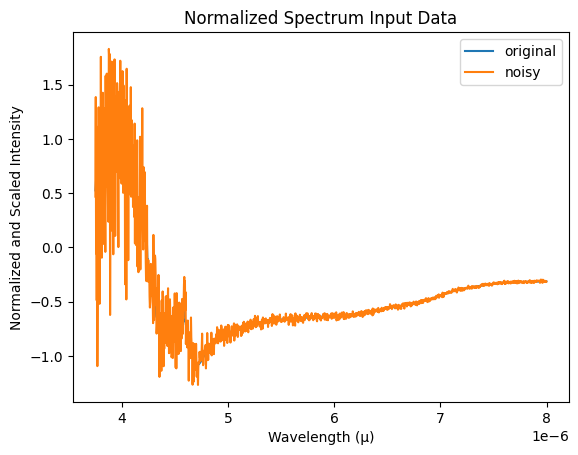

In [14]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [15]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [16]:
# Feature Selection

In [17]:
spec_train

tensor([[-0.3860, -1.1078, -0.5738,  ..., -1.1251, -1.1200, -1.1153],
        [ 0.2235, -0.2993,  1.0468,  ...,  1.6762,  1.6670,  1.6824],
        [-1.9564, -1.3467, -1.1986,  ..., -0.6930, -0.6899, -0.6882],
        ...,
        [-1.2441, -1.0563, -1.9528,  ..., -1.0043, -1.0078, -1.0082],
        [-0.1480,  1.1334,  1.6541,  ...,  0.2136,  0.2198,  0.2206],
        [ 0.0615, -1.0944, -0.5280,  ...,  1.4646,  1.4689,  1.4664]])

In [18]:
temp_train

tensor([[279.2097, 291.1372, 304.6712,  ..., 309.0874, 307.9146, 287.3898],
        [284.7944, 309.4465, 334.0897,  ..., 303.7473, 311.2545, 366.0722],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [293.5930, 300.5022, 312.8386,  ..., 306.9922, 292.7501, 293.1349],
        [337.4347, 345.6631, 344.0024,  ..., 324.8639, 323.7931, 333.0087],
        [293.4902, 286.4892, 303.6414,  ..., 345.2938, 341.2333, 361.8345]])

# Model Design

In [20]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [21]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
inverse_model = InverseNet(io_size, middle_size)

pred_temp = inverse_model(spec_train)


# Training Loop

In [23]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    inverse_loss_list = []
    
    inverse_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](inverse_model.parameters(), lr=args['inverse learning rate'])

    for epoch in range(num_inverse_epochs):

        pred_temp = inverse_model(spec_train)

        # calculate inverse loss (to see spec to temp accuracy)
        inverse_loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        inverse_loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            inverse_loss_sum += inverse_loss.item()

        inverse_loss_list.append(inverse_loss.item())

    print(f'inverse epoch: {epoch + 1}, inverse loss = {inverse_loss}')

    avg_inverse_loss = inverse_loss_sum / (num_inverse_epochs - 100)
    print(f'\naverage inverse training loss (across all layers): {avg_inverse_loss}')
    
    return inverse_loss_list

In [24]:
inverse_loss_list = train_inverse_model(inverse_model, spec_train)


INVERSE MODEL TRAINING


inverse epoch: 5000, inverse loss = 4.569504737854004

average inverse training loss (across all layers): 4.697583447378509


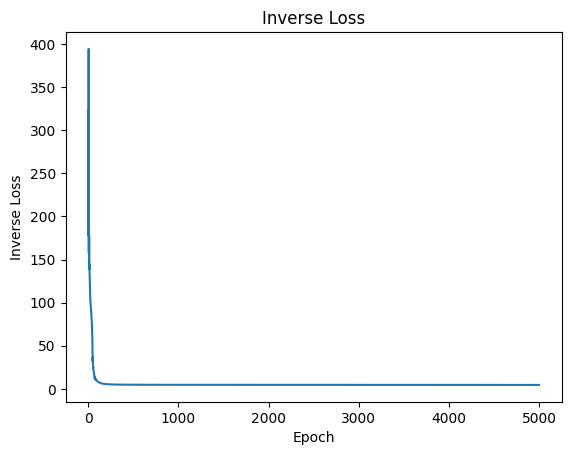

In [25]:
# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [26]:
# test data
pred_temp = inverse_model(spec_test)

In [27]:
# unscale spectrum data
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [28]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [5.504040989731298, 9.626093130400687, 6.558718317205256, 5.894794440991951, 5.569419490929806, 6.018109315814394, 5.993191805752841, 4.639404389352509, 4.568700015906131, 5.901165910200639, 2.4365008729876894]


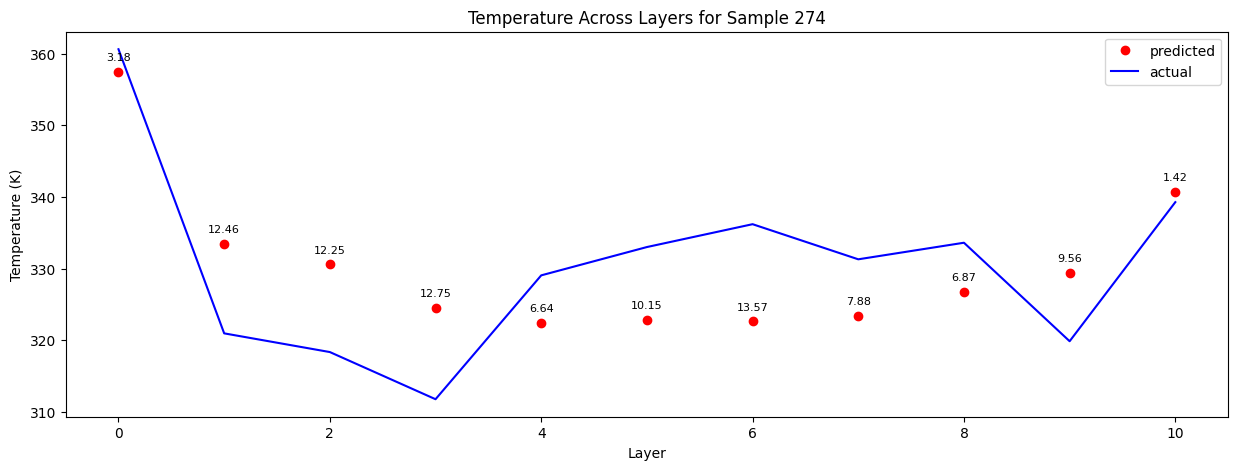

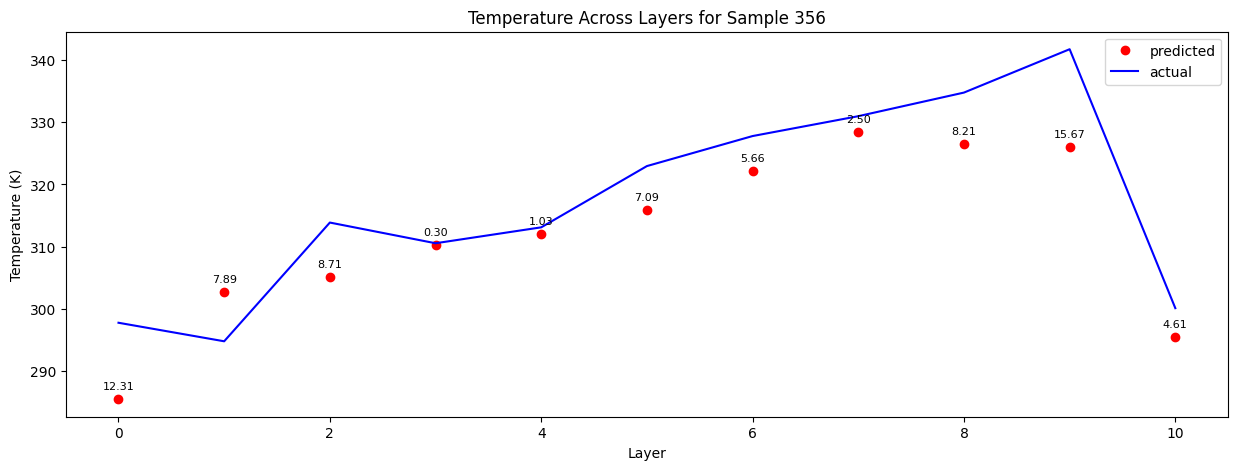

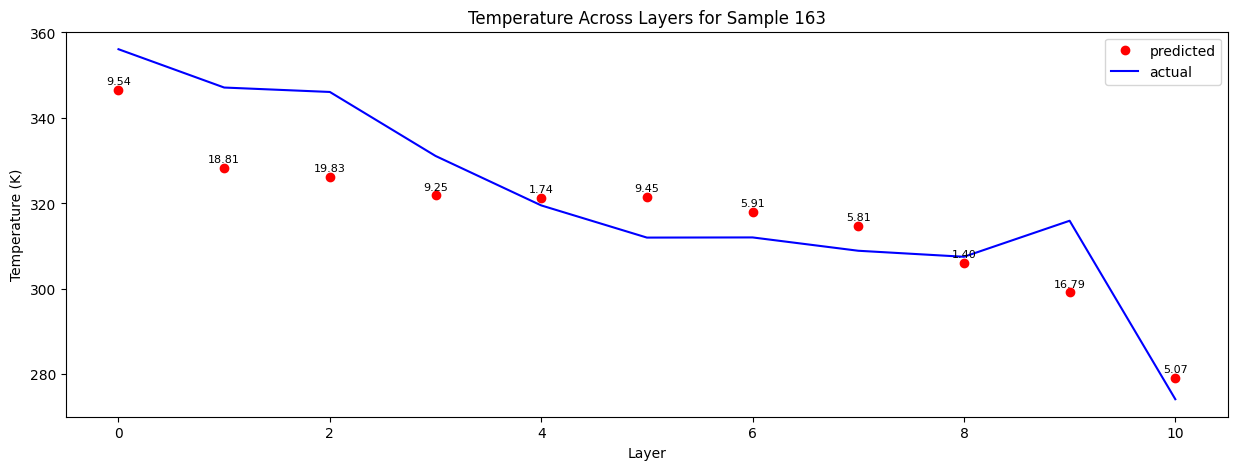

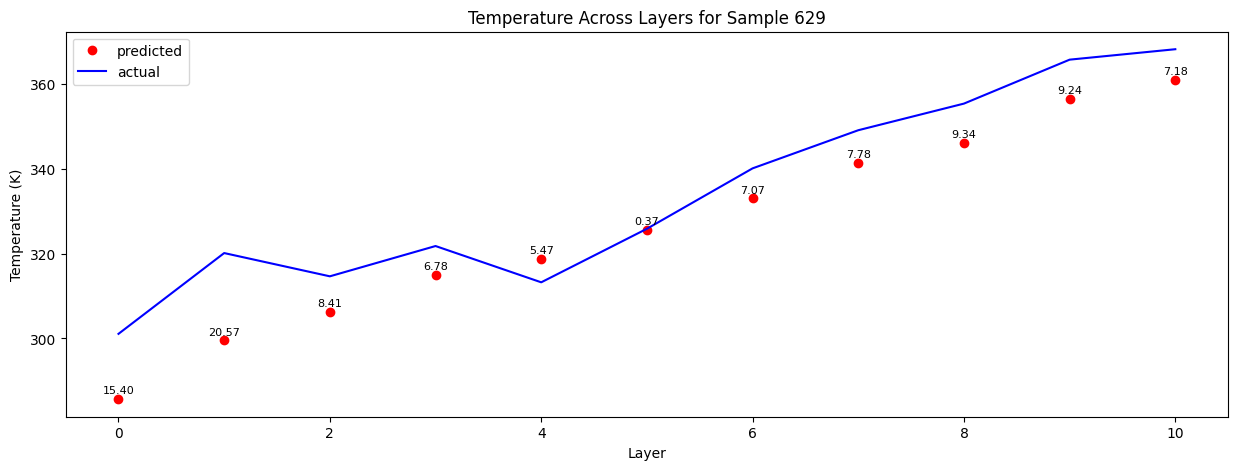

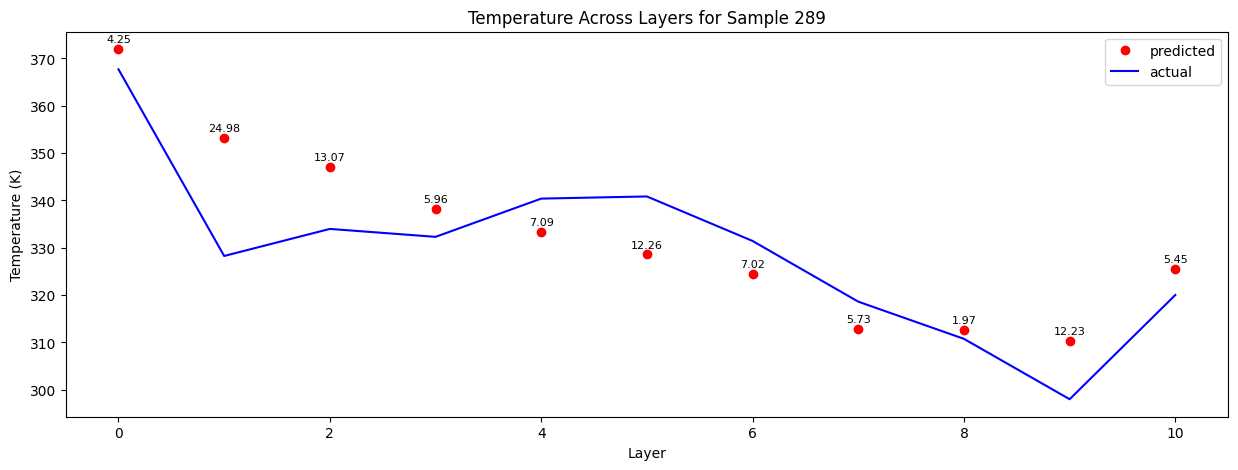

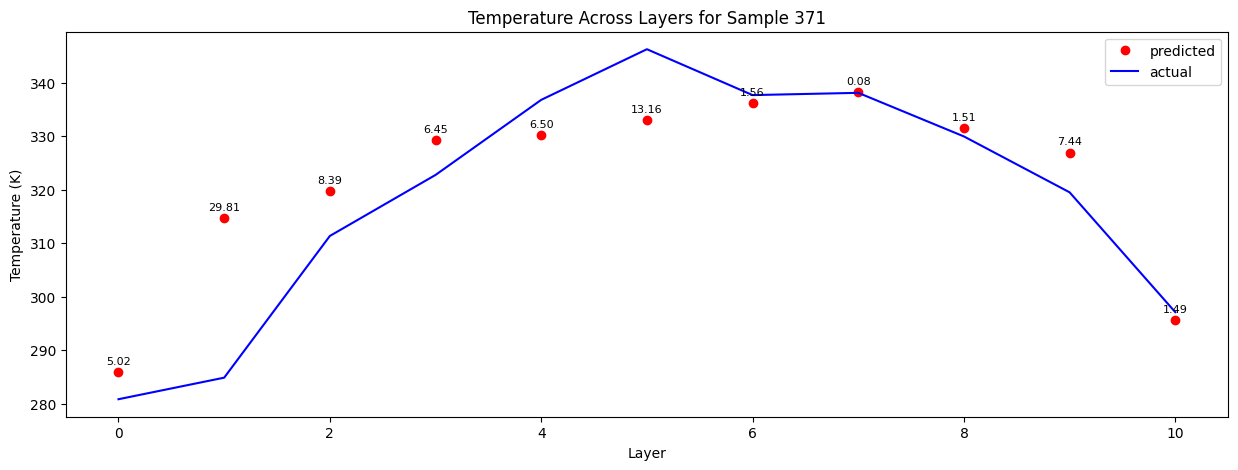

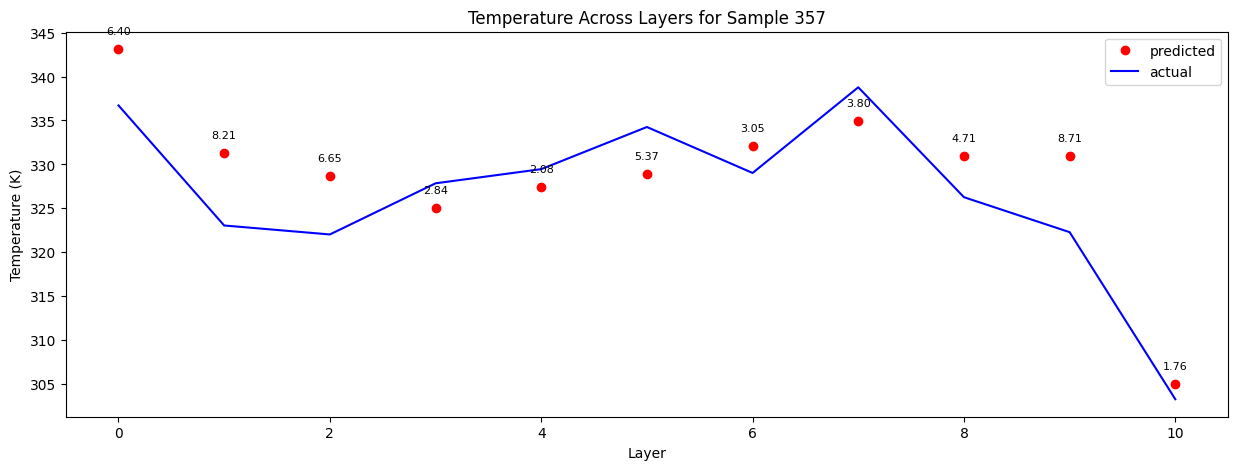

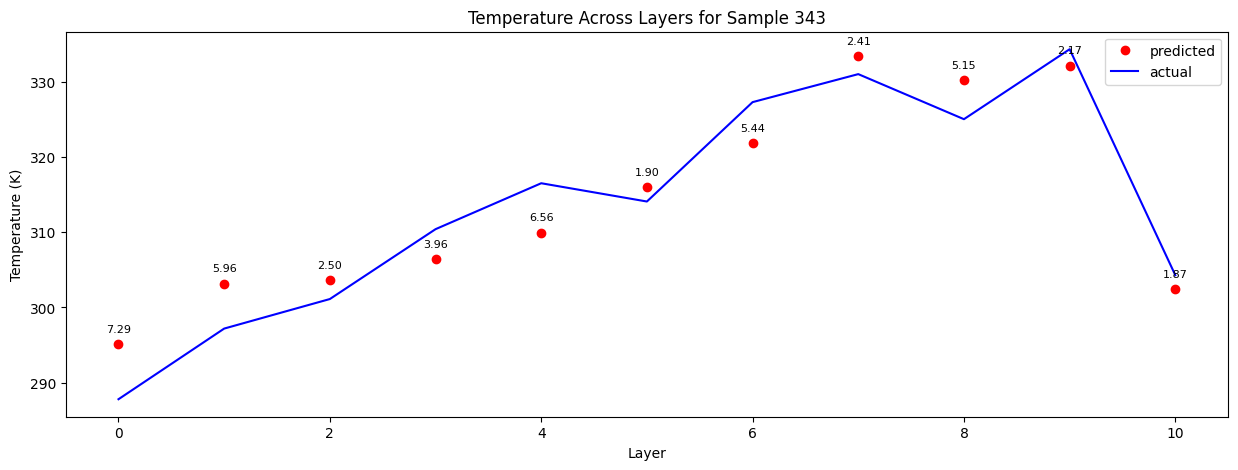

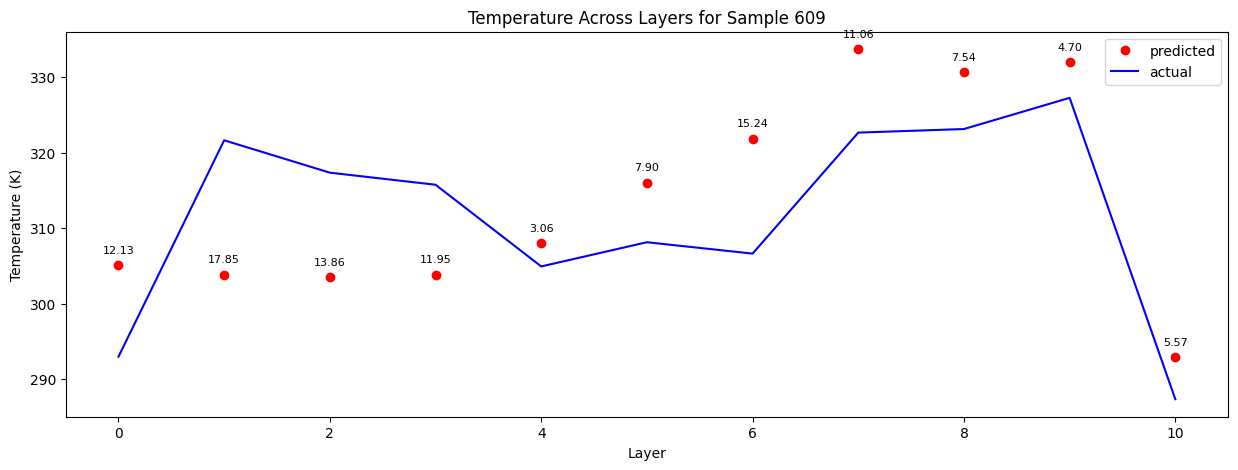

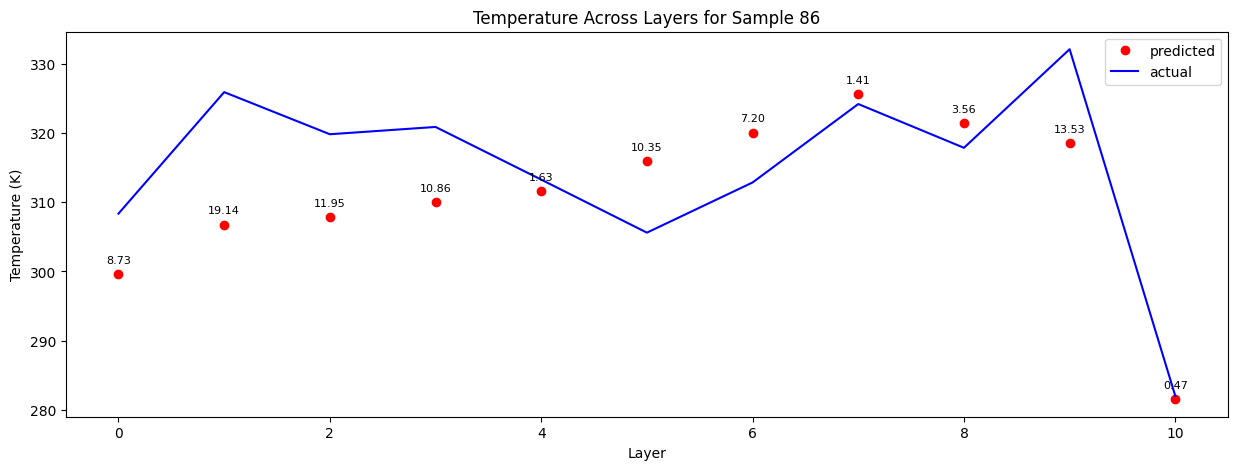

In [33]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


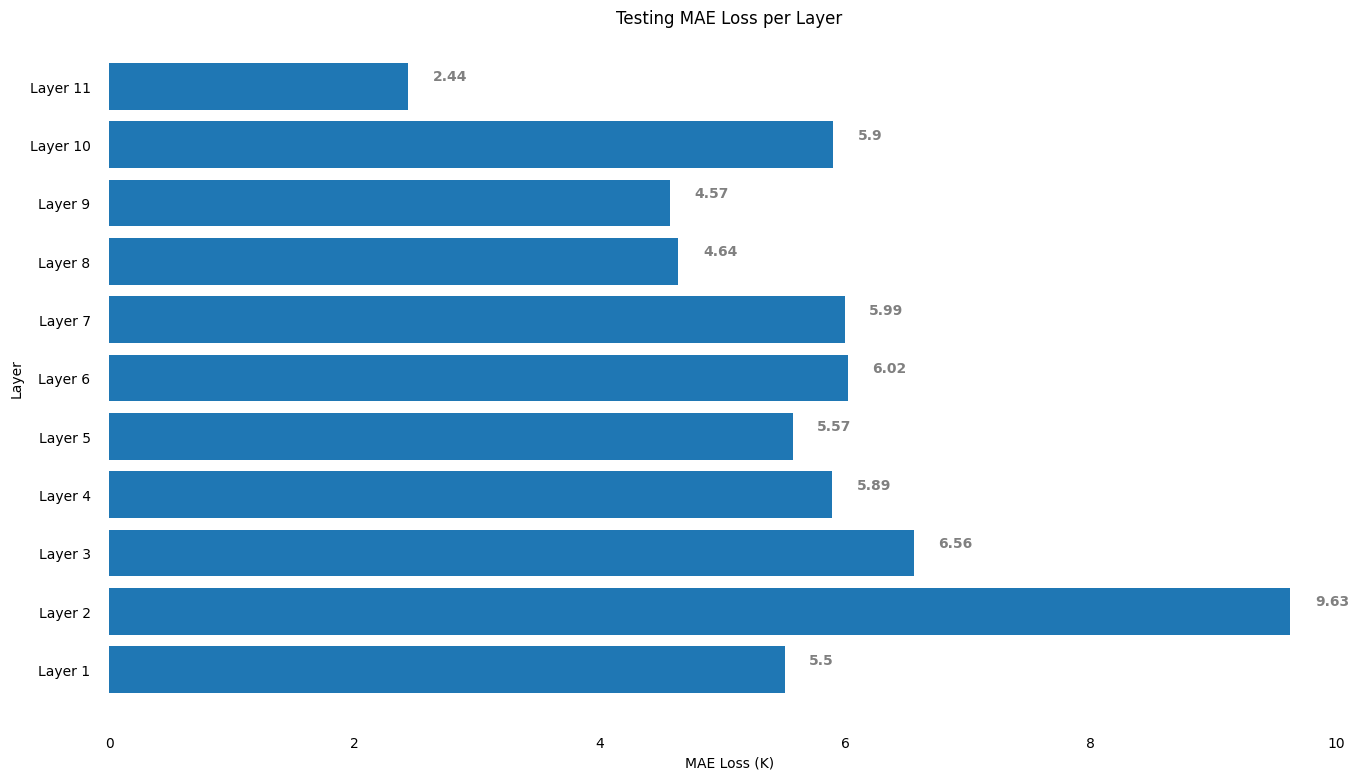

In [30]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()